This notebook shows and analyzes the results of the sample size experiment.

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, scipy, time, warnings
from sklearn.metrics import r2_score, log_loss,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, balanced_accuracy_score, roc_auc_score, classification_report

In [4]:
from methods.utils import CB_color_cycle, colors, METRIC_MAPPER

colors['TEST_SET']='black' #overwrite cause reddis/brownish colors are next to each other here.

In [5]:
ORDER = ['TEST_SET','RT-mod', 'ATC', 'DOC', 'CBPE', 'IW', 'PAPE', ]

In [6]:
pd.set_option('display.max_columns', 100)

# Load data

In [7]:
metrics = ['accuracy', 'roc_auc', 'f1']

In [8]:
df = pd.read_parquet('sample_size_experiment_results/experiment_chunk_size_effect.pq')

In [9]:
df['method'].value_counts()

PAPE        6789
TEST_SET    6789
DOC         6789
IW          6789
CBPE        6789
RT          6789
ATC         6789
Name: method, dtype: int64

In [10]:
df['evaluation_case'] = df[['dataset', 'monitored_model', 'chunksize']].astype(str).agg('-'.join, axis=1)

In [11]:
# data with standard deviations/standard errors per evaluation case
stds = pd.read_parquet('sample_size_experiment_results/STD_results.pq') 
stds['evaluation_case'] = stds[['dataset', 'monitored_model', 'chunksize']].astype(str).agg('-'.join, axis=1)
stds = stds[['evaluation_case', 'std_accuracy', 'std_roc_auc','std_f1', ]]

In [12]:
df = pd.merge(df, stds, on='evaluation_case') 

In [13]:
df.head()

,method,dataset,monitored_model,accuracy,est_accuracy,roc_auc,est_roc_auc,f1,est_f1,period,chunksize,step,evaluation_case,std_accuracy,std_roc_auc,std_f1
0,PAPE,employment-2015_2016_2017_2018-CA.pq,LGBMClassifier_,0.83,0.840688,0.877551,0.901566,0.838095,0.844417,reference,100,1000,employment-2015_2016_2017_2018-CA.pq-LGBMClass...,0.037842,0.030206,0.043526
1,PAPE,employment-2015_2016_2017_2018-CA.pq,LGBMClassifier_,0.88,0.886251,0.938611,0.944643,0.857143,0.863683,reference,100,1000,employment-2015_2016_2017_2018-CA.pq-LGBMClass...,0.037842,0.030206,0.043526
2,PAPE,employment-2015_2016_2017_2018-CA.pq,LGBMClassifier_,0.82,0.831135,0.887473,0.901846,0.763158,0.787560,reference,100,1000,employment-2015_2016_2017_2018-CA.pq-LGBMClass...,0.037842,0.030206,0.043526
3,PAPE,employment-2015_2016_2017_2018-CA.pq,LGBMClassifier_,0.85,0.819742,0.923232,0.901541,0.827586,0.787752,reference,100,1000,employment-2015_2016_2017_2018-CA.pq-LGBMClass...,0.037842,0.030206,0.043526
4,PAPE,employment-2015_2016_2017_2018-CA.pq,LGBMClassifier_,0.86,0.831525,0.929487,0.914562,0.857143,0.826396,reference,100,1000,employment-2015_2016_2017_2018-CA.pq-LGBMClass...,0.037842,0.030206,0.043526


## Preprocess: Add Constant Corrected Reverse Training

As described in the paper, for Reverse Training we apply constant correction so that the performance estimated by this method on reference data (where labels are available) matches, on average, the realized performance. Otherwise the estimates were biased and uncomparable to other methods. We keep the original method for investigation.

In [14]:
RT = df[df['method']=='RT']
RT_ref = RT[RT['period']=='reference'].copy()

RT_corrected = RT.copy()
for metric in metrics:
    RT_ref[metric + '_diff_on_reference'] = RT_ref[metric] - RT_ref['est_' + metric] # difference between realized and estimated on reference chunks
    constant_correction_for_RT = RT_ref.groupby('evaluation_case')[metric + '_diff_on_reference'].mean().reset_index(drop=False) # get mean difference per evaluation case
    RT_corrected = pd.merge(RT_corrected, constant_correction_for_RT, left_on='evaluation_case', right_on='evaluation_case')
    RT_corrected['est_' + metric] = RT_corrected['est_' + metric] + RT_corrected[metric + '_diff_on_reference']
    RT_corrected = RT_corrected.drop(columns=[metric + '_diff_on_reference'])

RT_corrected['method'] = 'RT-mod'
df = pd.concat([df, RT_corrected]).reset_index(drop=True)

In [15]:
df.groupby('method')['method'].count()

method
ATC         6789
CBPE        6789
DOC         6789
IW          6789
PAPE        6789
RT          6789
RT-mod      6789
TEST_SET    6789
Name: method, dtype: int64

# Analyze the results

In [16]:
dfa = df[df['period']=='production'].copy()

In [17]:
for metric in ['accuracy', 'roc_auc', 'f1']:
    dfa['E_' + metric] = dfa[metric]-dfa['est_' + metric]
    dfa['AE_' + metric] = abs(dfa[metric]-dfa['est_' + metric])
    dfa['SE_' + metric] = (dfa[metric]-dfa['est_' + metric])**2


In [18]:
dfa['method'].value_counts()

PAPE        4532
TEST_SET    4532
DOC         4532
IW          4532
CBPE        4532
RT          4532
ATC         4532
RT-mod      4532
Name: method, dtype: int64

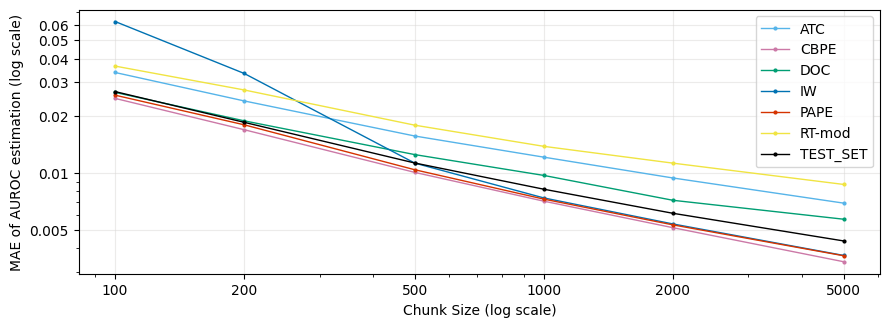

In [19]:
metric = 'roc_auc'
keep_methods = ORDER
plt.figure(figsize=(9,3/8*9))
for method_name, method_data in dfa.groupby('method'):
    chs, metrics = [], []
    if method_name not in keep_methods:
        continue
    for chunksize, chunksize_data in method_data.groupby('chunksize'):
        MAE = np.mean(chunksize_data['AE_' + metric])
        chs.append(int(chunksize))
        metrics.append(MAE)
    plt.plot(chs, metrics, 'o-', label=method_name, color=colors[method_name], linewidth=1, markersize=2)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=1)
plt.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=1)
plt.xticks(ticks=chs, labels=chs)
plt.yticks(ticks=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06], labels=[0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06])
plt.xlabel('Chunk Size (log scale)')
plt.ylabel('MAE of AUROC estimation (log scale)')

plt.tight_layout()
plt.savefig('figures/chunksize_effect.png', dpi=320)

plt.show()